# Statistical Factor Model on Major Indices across the World

## Introduction
In this notebook, we are going to investigate the risk exposures of the major indices. We try to identify macro factors, such as major currency pairs, commodity, CDS indices, etc., that are highly correlation with the indices. Then, we perform a multivariate linear regression on index returns against macro factors to get the betas.

We first import the required libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, probplot
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

The data set contains two sheets: `equity` which contains indices level and `factor` containing marcro data from 2005 to 2017. The table below shows all the indices and macro factors

| Equity Index  | Marco Factor               |
|---------------|----------------------------|
| NKY Index     | AUDJPY CURNCY              |
| HSI Index     | EUR Curncy                 |
| AS51 Index    | JPY CURNCY                 |
| HSCEI Index   | CHF CURNCY                 |
| SHSZ300 Index | CNY CURNCY                 |
| TWSE Index    | INR CURNCY                 |
| KOSPI Index   | DXY CURNCY                 |
| NIFTY Index   | XAU Curncy                 |
| FSSTI Index   | XAG Curncy                 |
| SPX Index     | GBP Curncy                 |
| NDX Index     | PLAT COMDTY                |
| ibov Index    | CL1 COMDTY                 |
| SX5E Index    | CO1 COMDTY                 |
| UKX Index     | NG1 Comdty                 |
| CAC Index     | HG1 COMDTY                 |
| DAX Index     | W 1 Comdty                 |
| SMI Index     | C 1 Comdty                 |
| IBEX Index    | BASPTDSP Index             |
| OMX Index     | XOVER CDSI GENERIC 5Y Corp |
| AEX Index     | CITLY1U5 Index             |
|               | CDBR1U5 Index              |
|               | CJGB1U5 Index              |
|               | SPAIN CDS USD SR 5Y Corp   |
|               | BICLOISS Index             |


In [2]:
sheets = ['equity', 'factor']
equity, factor = [pd.read_excel("Factor Model.xlsx", sheet_name=sheet, index_col=0, parse_dates=True) for sheet in sheets]

In [3]:
equity.head(5).style.set_caption('Equity Data')

In [4]:
factor.head(5).style.set_caption('Factor Data')

## Calculate Log Return
We first calculate the monthly log return of the indices and factors.

In [5]:
equity_return = np.log(equity).diff().dropna()  # log return
factor_return = np.log(factor).diff().dropna()

## Dimension Reduction
To reduce the dimension of the index return, we apply PCA to the data and keep the principal components (PCs) such that they explain at least 80% of the variance. It turns out that we need 3 PCs.

No. of components required: 3


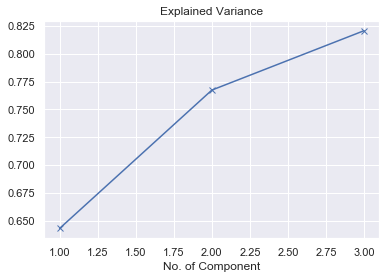

In [6]:
reqExp = 0.8
reqCorr = 0.4
reqFcorr = 0.7

pca = PCA(reqExp).fit(equity_return)
n = pca.n_components_
print(f"No. of components required: {n}")
sns.set()
plt.plot(range(1, n+1), np.cumsum(pca.explained_variance_ratio_), marker='x')
plt.xlabel("No. of Component")
plt.title('Explained Variance')
PCs = pca.transform(equity_return).transpose()

## Factor Selection
We want to identify which macro factors are correlated to the indices. Therefore, we check the correlation between each macro factors and the first 3 PCs, and keep the factors that have higher than 0.4 correlation (in absolute value). Since macro factors are highly collinear in nature, in order to avoid final model being inefficient, we define a correlation limit (70%) on each chosen factor with the existing ones. Factors having correlation high than 0.7 with other factors will not be selected.

In [7]:
selected_factors = []
all_factors = list(factor_return.columns)
all_factors[1], all_factors[6] = all_factors[6], all_factors[1]  

for PC in PCs:
    for factor in all_factors:
        corr = abs(pearsonr(PC, factor_return[factor])[0])
        if len(selected_factors) == 0:
            if corr > reqCorr:
                selected_factors.append(factor)
        else:
            Fcorr = [abs(pearsonr(factor_return[factor], factor_return[sel_fact])[0]) for sel_fact in selected_factors]
            if corr > reqCorr and max(Fcorr) < reqFcorr:  # check if the correlations between every selected factor and new factor is smaller than 0.7
                selected_factors.append(factor)
print("Selected factors: ")
print(selected_factors)

Selected factors: 
['AUDJPY CURNCY', 'DXY CURNCY', 'INR CURNCY', 'GBP Curncy', 'CL1 COMDTY', 'HG1 COMDTY', 'XOVER CDSI GENERIC 5Y Corp', 'CITLY1U5 Index', 'CDBR1U5 Index', 'CJGB1U5 Index']


Once we have selected the factors, we normalize the index returns and factor returns by $\frac {x-\mu}{\sigma}$.

In [8]:
def normalize(df):
    return (df - df.mean()) / df.std()
norm_fact = normalize(factor_return[selected_factors])
norm_equity = normalize(equity_return)

## Factor Loadings
We regress the index returns on the macro factors (multivariate linear regressions). Factor loadings of the first 3 indice are plotted as an illustration.

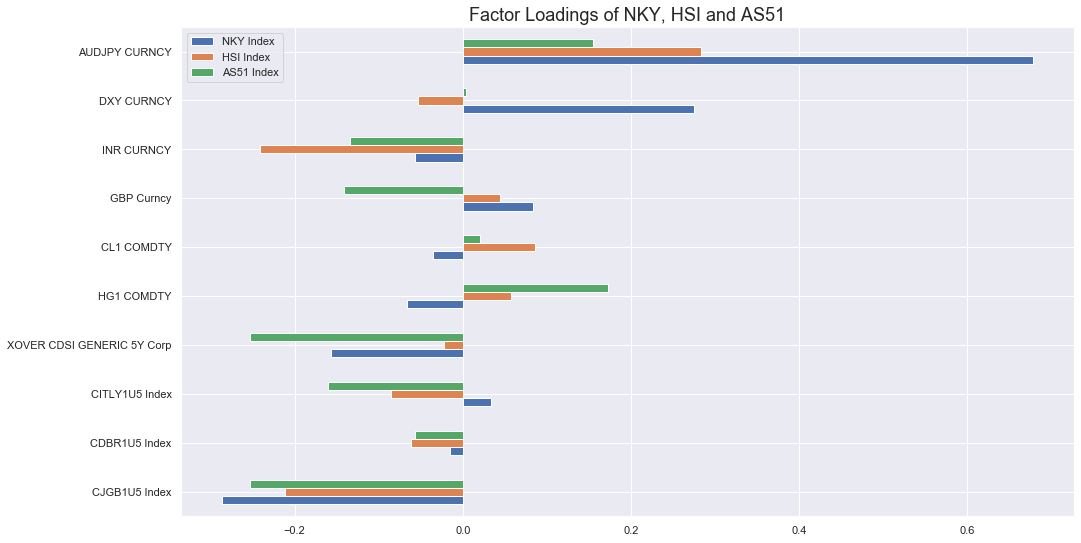

In [9]:
reg = LinearRegression().fit(norm_fact, norm_equity)
coef = pd.DataFrame(reg.coef_, columns=selected_factors, index=equity_return.columns)

bar_width = 0.25
index = np.arange(coef.shape[1])
coef.head(3).transpose()[::-1].plot.barh(figsize=(16,9))
plt.title('Factor Loadings of NKY, HSI and AS51', fontsize=18)
plt.show()

# Conditional Formatting
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color
coef.style.set_caption('Factor Loadings of all indices').applymap(color_negative_red)

## Regression Diagnotics

### Normality of residual
We look at the QQ-plots of the regression residuals. The residuals of the majority of the indices fits the straight line quite well, indicating that the residuals are normally distributed.

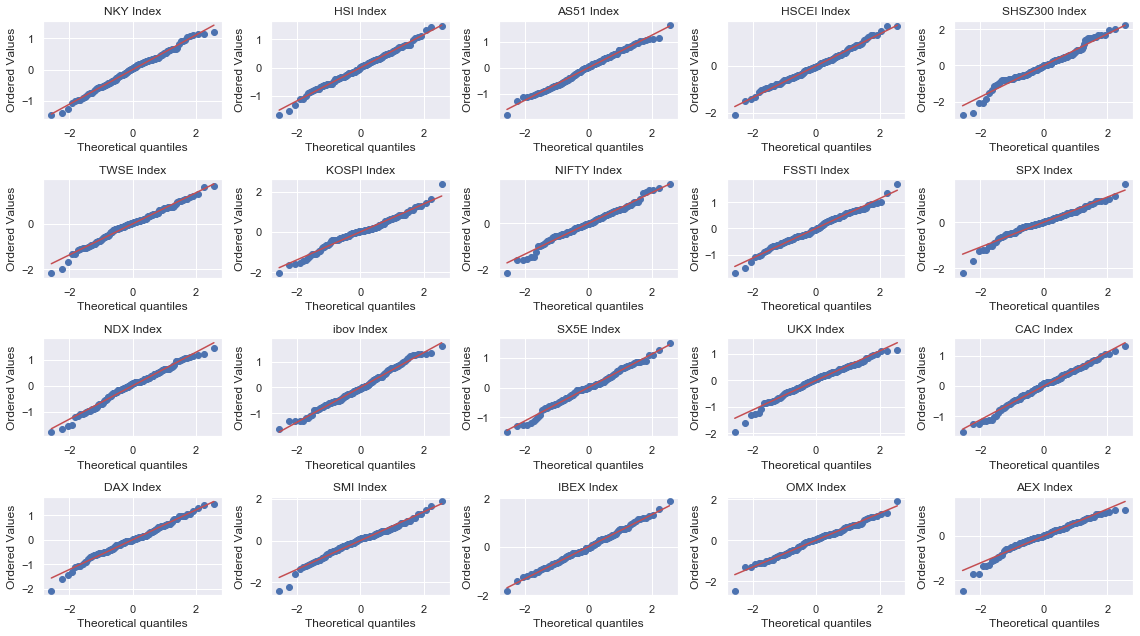

In [10]:
norm_fact_X = sm.add_constant(norm_fact)
regs = [sm.OLS(norm_equity[column], norm_fact_X).fit() for column in norm_equity.columns]
# beta = [regs[i].params for i in range(len(regs))]

## QQplot
fig, axes = plt.subplots(4,5, figsize=(16,9))
for i, ax in enumerate(axes.flat):
    probplot(regs[i].resid, plot=ax)
    ax.set_title(norm_equity.columns[i])
plt.tight_layout()
plt.show()

## R-squared and t-values
Furthermore, we can look at the R-squared values to see how much variance the model explained. Most of the R-squared values are around 0.6, which shows that the model is reasonable. The R-squared for SHSZ300 is about 0.2, which is significantly low. The reason is that the Chinese financial market mainly depends on internal economy. The currency pairs, commodities and CDS cannot explain much about the Chinese financial market.

In addition, the t-values of betas are shown in the table below for reference.

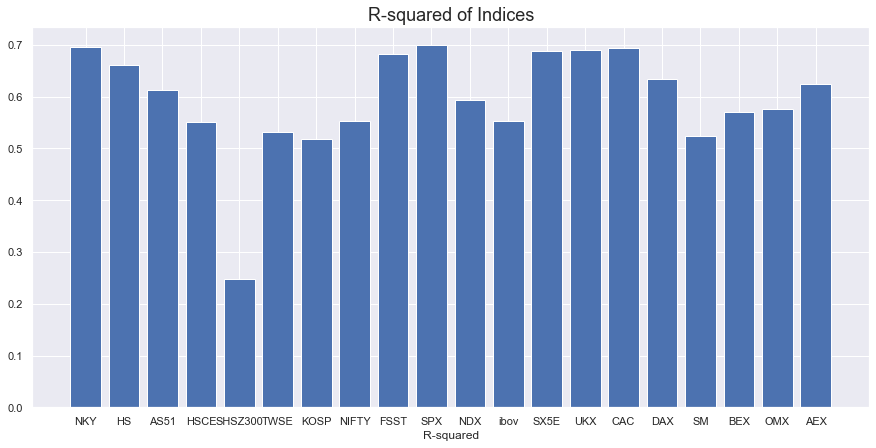

In [11]:
tvalue = [regs[i].tvalues for i in range(len(regs))]
Rsq = [regs[i].rsquared for i in range(len(regs))]

# R squared
plt.figure(figsize=(15,7))
plt.bar(list(map(lambda x: x.strip(' Index'), norm_equity.columns)), Rsq)
plt.xlabel('R-squared')
plt.title('R-squared of Indices', fontsize=18)
plt.show()

pd.DataFrame(tvalue, index=norm_equity.columns).style.set_caption('t-values')

## Findings
### All indices *positively correlates* with AUDJPY. 
`AUDJPY` is a strong indicator of future risk-on activity in global markets. If AUDJPY is bullish, risky assets tend to perform well. Thus, it is very natural that `AUDJPY` have a high correlation with the index returns. Furthermore, the betas of `AUDJPY` for all indices is high in general, which means that the indices have high exposures in `AUDJPY`.

### Nearly all indices have a *negative relationship* with the Indian rupee (INR) and CDS spread
The beta of INR in all indices (except `NIFTY 50`, which is the Indian stock market index) are negative. A possible reason is that the global economy correlates negatively with Indian economy. For CDS spread, it directly relates to the default probability of a company / country. Higher spread implies higher default probability. Thus, it is not surprising that it correlates negatively with the indices.

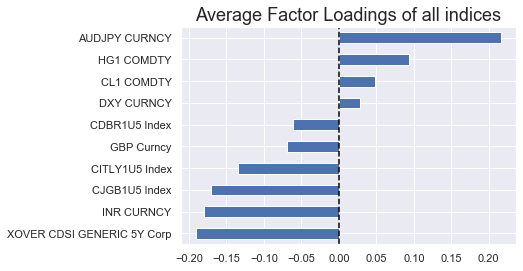

In [12]:
plt.figure()
coef.mean().sort_values().plot.barh()
plt.title("Average Factor Loadings of all indices", fontsize=18)
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

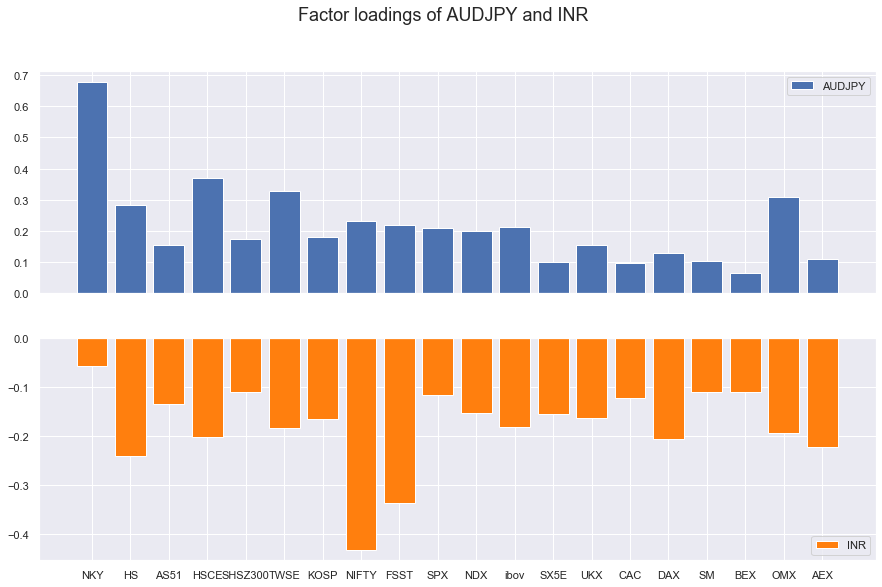

In [13]:
index = list(map(lambda x: x.strip(' Index'), coef.index))
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,9))
axes[0].bar(index, coef['AUDJPY CURNCY'], label='AUDJPY')
axes[1].bar(index, coef['INR CURNCY'], color='#ff7f0e', label='INR')
axes[0].legend(loc='upper right')
axes[1].legend(loc='lower right')
fig.suptitle('Factor loadings of AUDJPY and INR', fontsize=18)
plt.show()